<a href="https://colab.research.google.com/github/Barissdal/Diabete-Cluster-Analysis/blob/main/Cluster_and_Isolation_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
!pip install skompiler

     |████████████████████████████████| 45 kB 4.0 MB/s 
  Created wheel for skompiler: filename=SKompiler-0.6-py3-none-any.whl size=54286 sha256=986998aa0c4fea6385eb4c70c2fcbfdba29537b0cc99ac036746b0f6f97f632e
  Stored in directory: /root/.cache/pip/wheels/47/1c/59/b80a730f4afd2144bad854df4b167b812486c9d4c1bd4cf4c5
Successfully built skompiler


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,ShuffleSplit,GridSearchCV
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs,make_moons
from yellowbrick.cluster import KElbowVisualizer
import time
from matplotlib.colors import ListedColormap
from skompiler import skompile
from joblib import dump, load
from sklearn.ensemble import IsolationForest

In [5]:
df_ = pd.read_csv("/content/drive/MyDrive/resource/diabetes.csv")

In [6]:
df = df_.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [12]:
def grab_col_names(dataframe, cat_th=3, car_th=10):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [13]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [14]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [15]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


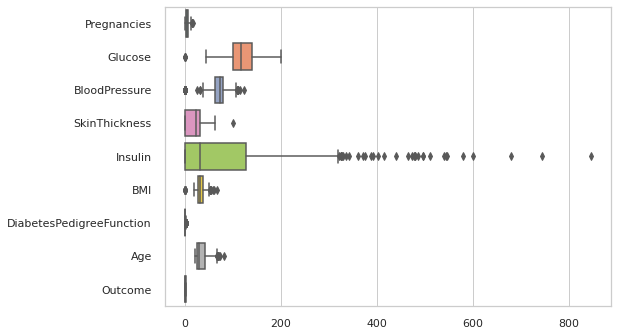

In [16]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=df, orient="h", palette="Set2")
plt.show()

In [17]:
df.isnull().values.any()

False

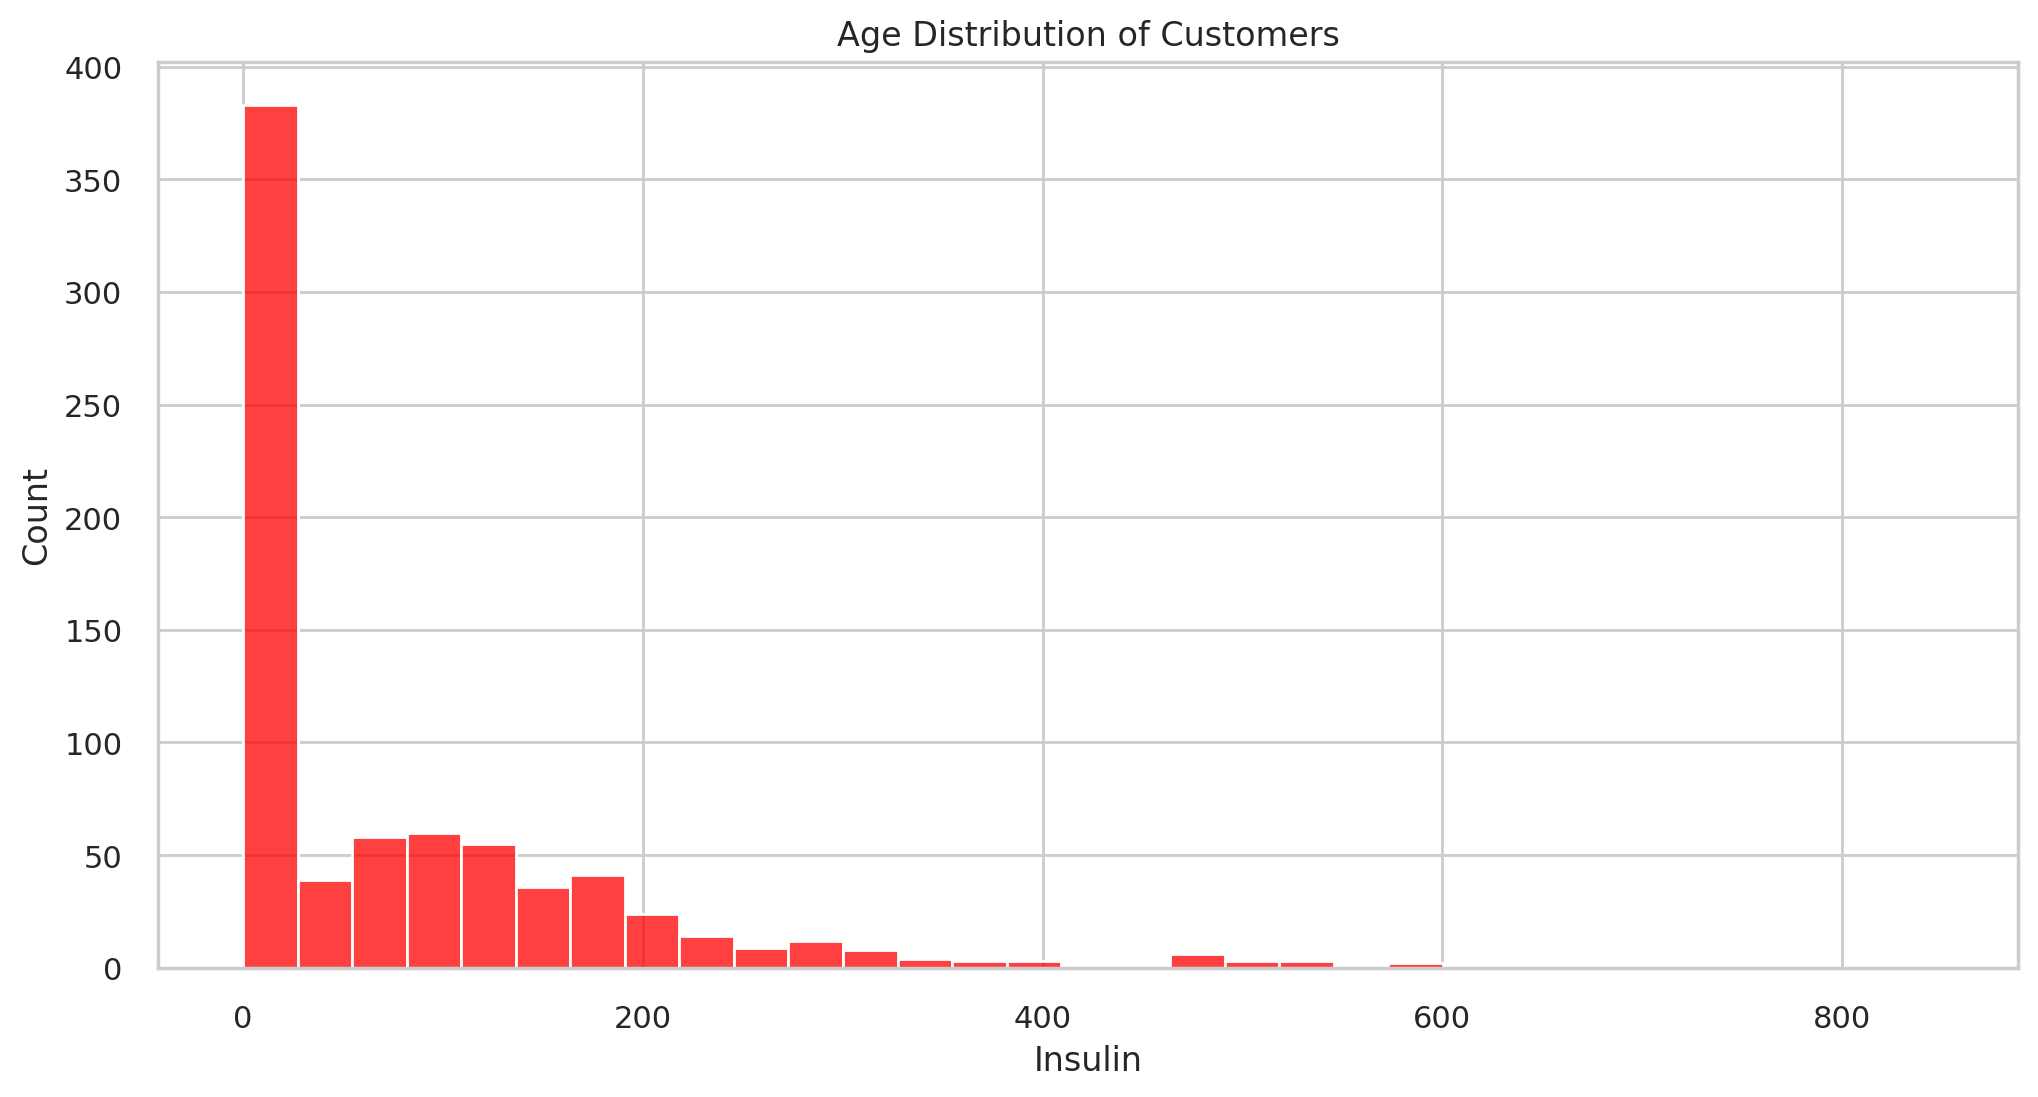

In [18]:
plt.figure(figsize=(12,6),dpi=200)
sns.histplot(data=df,x="Insulin",color="red")
plt.title("Age Distribution of Customers")
plt.show()

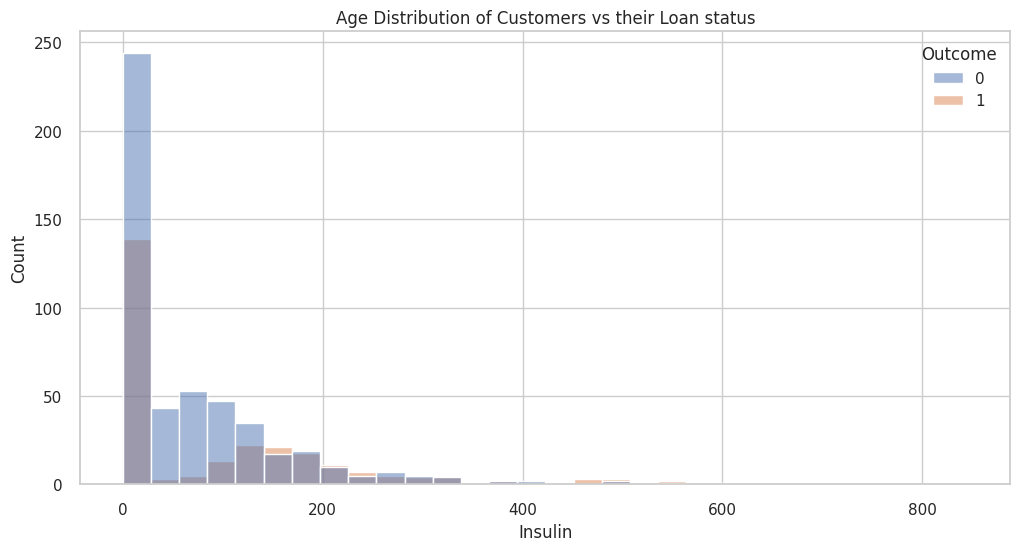

In [19]:
plt.figure(figsize=(12,6),dpi=100)
sns.histplot(data=df,x="Insulin",hue="Outcome",bins=30)
plt.title("Age Distribution of Customers vs their Loan status")
plt.show()

In [20]:
pd.DataFrame(df.Insulin.value_counts()).head()

,Insulin
0,374
105,11
140,9
130,9
120,8


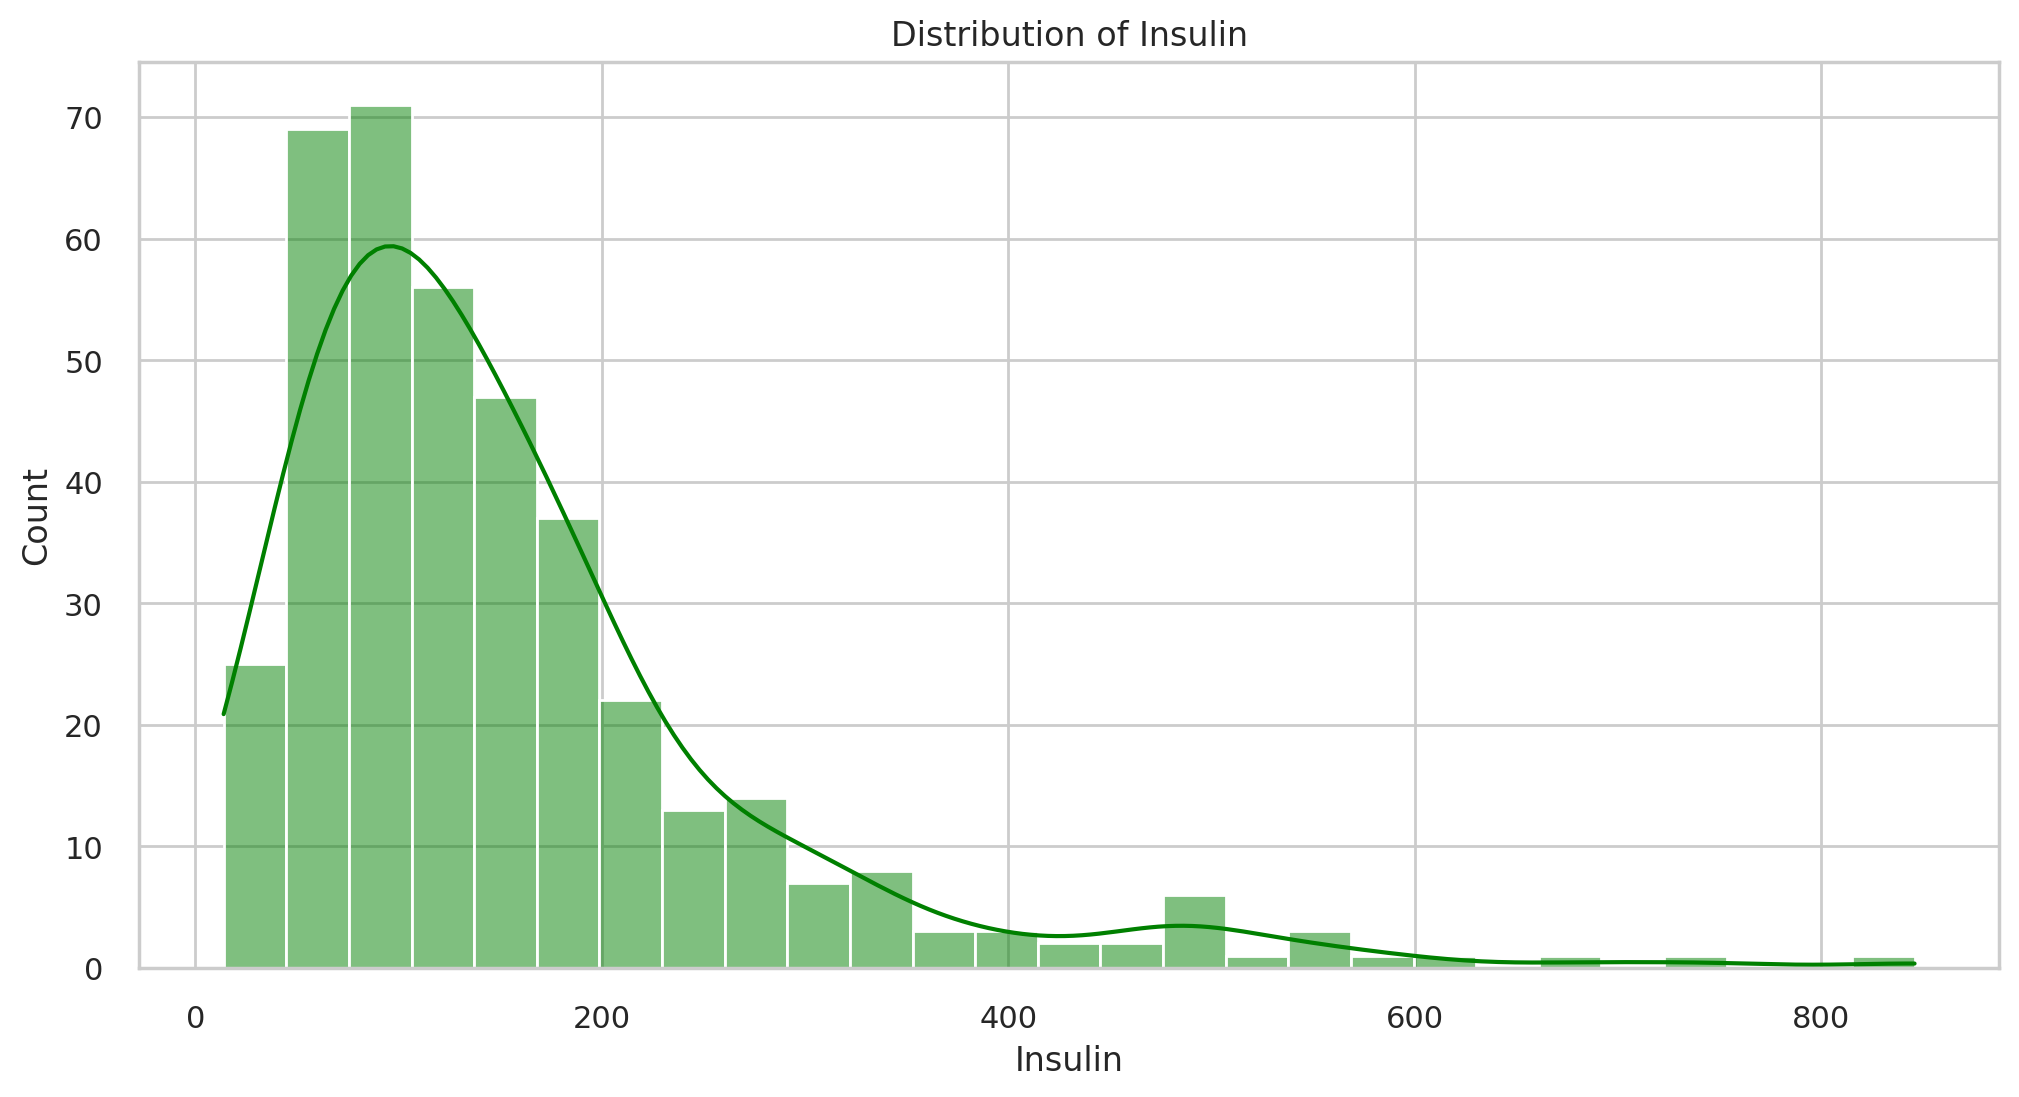

In [23]:
plt.figure(figsize=(12,6),dpi=200)
sns.histplot(data=df[df.Insulin!=0],x="Insulin",color="green",kde=True)
plt.title("Distribution of Insulin")
plt.show()

In [24]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Isolation Forest

In [25]:
model=IsolationForest(n_estimators=1000,max_samples='auto',contamination=float(0.2),max_features=1.0)
model.fit(df[['Insulin']])

IsolationForest(contamination=0.2, n_estimators=1000)

In [26]:
df['scores']=model.decision_function(df[['Insulin']])
df['anomaly']=model.predict(df[['Insulin']])
df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,scores,anomaly
0,6,148,72,35,0,33.6,0.627,50,1,0.094254,1
1,1,85,66,29,0,26.6,0.351,31,0,0.094254,1
2,8,183,64,0,0,23.3,0.672,32,1,0.094254,1
3,1,89,66,23,94,28.1,0.167,21,0,0.026364,1
4,0,137,40,35,168,43.1,2.288,33,1,0.006957,1
5,5,116,74,0,0,25.6,0.201,30,0,0.094254,1
6,3,78,50,32,88,31.0,0.248,26,1,0.022477,1
7,10,115,0,0,0,35.3,0.134,29,0,0.094254,1
8,2,197,70,45,543,30.5,0.158,53,1,-0.228159,-1
9,8,125,96,0,0,0.0,0.232,54,1,0.094254,1


In [29]:
df[df['anomaly'] == -1].Insulin.mean()

222.78571428571428

In [30]:
df.groupby(['anomaly']).Insulin.mean()

anomaly
-1    222.785714
 1     43.936482
Name: Insulin, dtype: float64

In [31]:
df_upg = df

In [32]:
df_upg["Insulin"].replace({0:np.nan},inplace=True)
df_upg['Insulin'] = df_upg['Insulin'].fillna(df_upg['Insulin'].median())

In [33]:
df_upg.groupby(['anomaly']).Insulin.mean()

anomaly
-1    222.785714
 1    120.076547
Name: Insulin, dtype: float64

Rebuild Isolation Forest

In [34]:
model=IsolationForest(n_estimators=1000,max_samples='auto',contamination=float(0.2),max_features=1.0)
model.fit(df_upg[['Insulin']])
df_upg['scores']=model.decision_function(df_upg[['Insulin']])
df_upg['anomaly']=model.predict(df_upg[['Insulin']])
df_upg.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,scores,anomaly
0,6,148,72,35,125.0,33.6,0.627,50,1,0.178338,1
1,1,85,66,29,125.0,26.6,0.351,31,0,0.178338,1
2,8,183,64,0,125.0,23.3,0.672,32,1,0.178338,1
3,1,89,66,23,94.0,28.1,0.167,21,0,0.027019,1
4,0,137,40,35,168.0,43.1,2.288,33,1,0.011802,1
5,5,116,74,0,125.0,25.6,0.201,30,0,0.178338,1
6,3,78,50,32,88.0,31.0,0.248,26,1,0.018921,1
7,10,115,0,0,125.0,35.3,0.134,29,0,0.178338,1
8,2,197,70,45,543.0,30.5,0.158,53,1,-0.226332,-1
9,8,125,96,0,125.0,0.0,0.232,54,1,0.178338,1


In [36]:
df_upg.groupby(['anomaly']).Insulin.mean()

anomaly
-1    215.379085
 1    122.086179
Name: Insulin, dtype: float64

In [37]:
df_anomaly = df[df['anomaly'] != -1]
df_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 767
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               615 non-null    int64  
 1   Glucose                   615 non-null    int64  
 2   BloodPressure             615 non-null    int64  
 3   SkinThickness             615 non-null    int64  
 4   Insulin                   615 non-null    float64
 5   BMI                       615 non-null    float64
 6   DiabetesPedigreeFunction  615 non-null    float64
 7   Age                       615 non-null    int64  
 8   Outcome                   615 non-null    int64  
 9   scores                    615 non-null    float64
 10  anomaly                   615 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 57.7 KB


In [38]:
df_study = df_anomaly.iloc[:,[0,1,2,3,4,5,6,7,8]]

In [39]:
df_study.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               615 non-null    int64  
 1   Glucose                   615 non-null    int64  
 2   BloodPressure             615 non-null    int64  
 3   SkinThickness             615 non-null    int64  
 4   Insulin                   615 non-null    float64
 5   BMI                       615 non-null    float64
 6   DiabetesPedigreeFunction  615 non-null    float64
 7   Age                       615 non-null    int64  
 8   Outcome                   615 non-null    int64  
dtypes: float64(3), int64(6)
memory usage: 48.0 KB


In [46]:
X = df_study.drop("Outcome",axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               615 non-null    int64  
 1   Glucose                   615 non-null    int64  
 2   BloodPressure             615 non-null    int64  
 3   SkinThickness             615 non-null    int64  
 4   Insulin                   615 non-null    float64
 5   BMI                       615 non-null    float64
 6   DiabetesPedigreeFunction  615 non-null    float64
 7   Age                       615 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 43.2 KB


In [47]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)
df_scaled[0]

array([0.59072735, 0.95665429, 0.17639419, 1.05271164, 0.12240876,
       0.26317305, 0.55348637, 1.38176006])

# Models

K-Means

In [48]:
k_means_model = KMeans(n_clusters=2)
k_means_model.fit(df_scaled)
cluster_labels = k_means_model.predict(df_scaled)
X["Cluster"] = cluster_labels

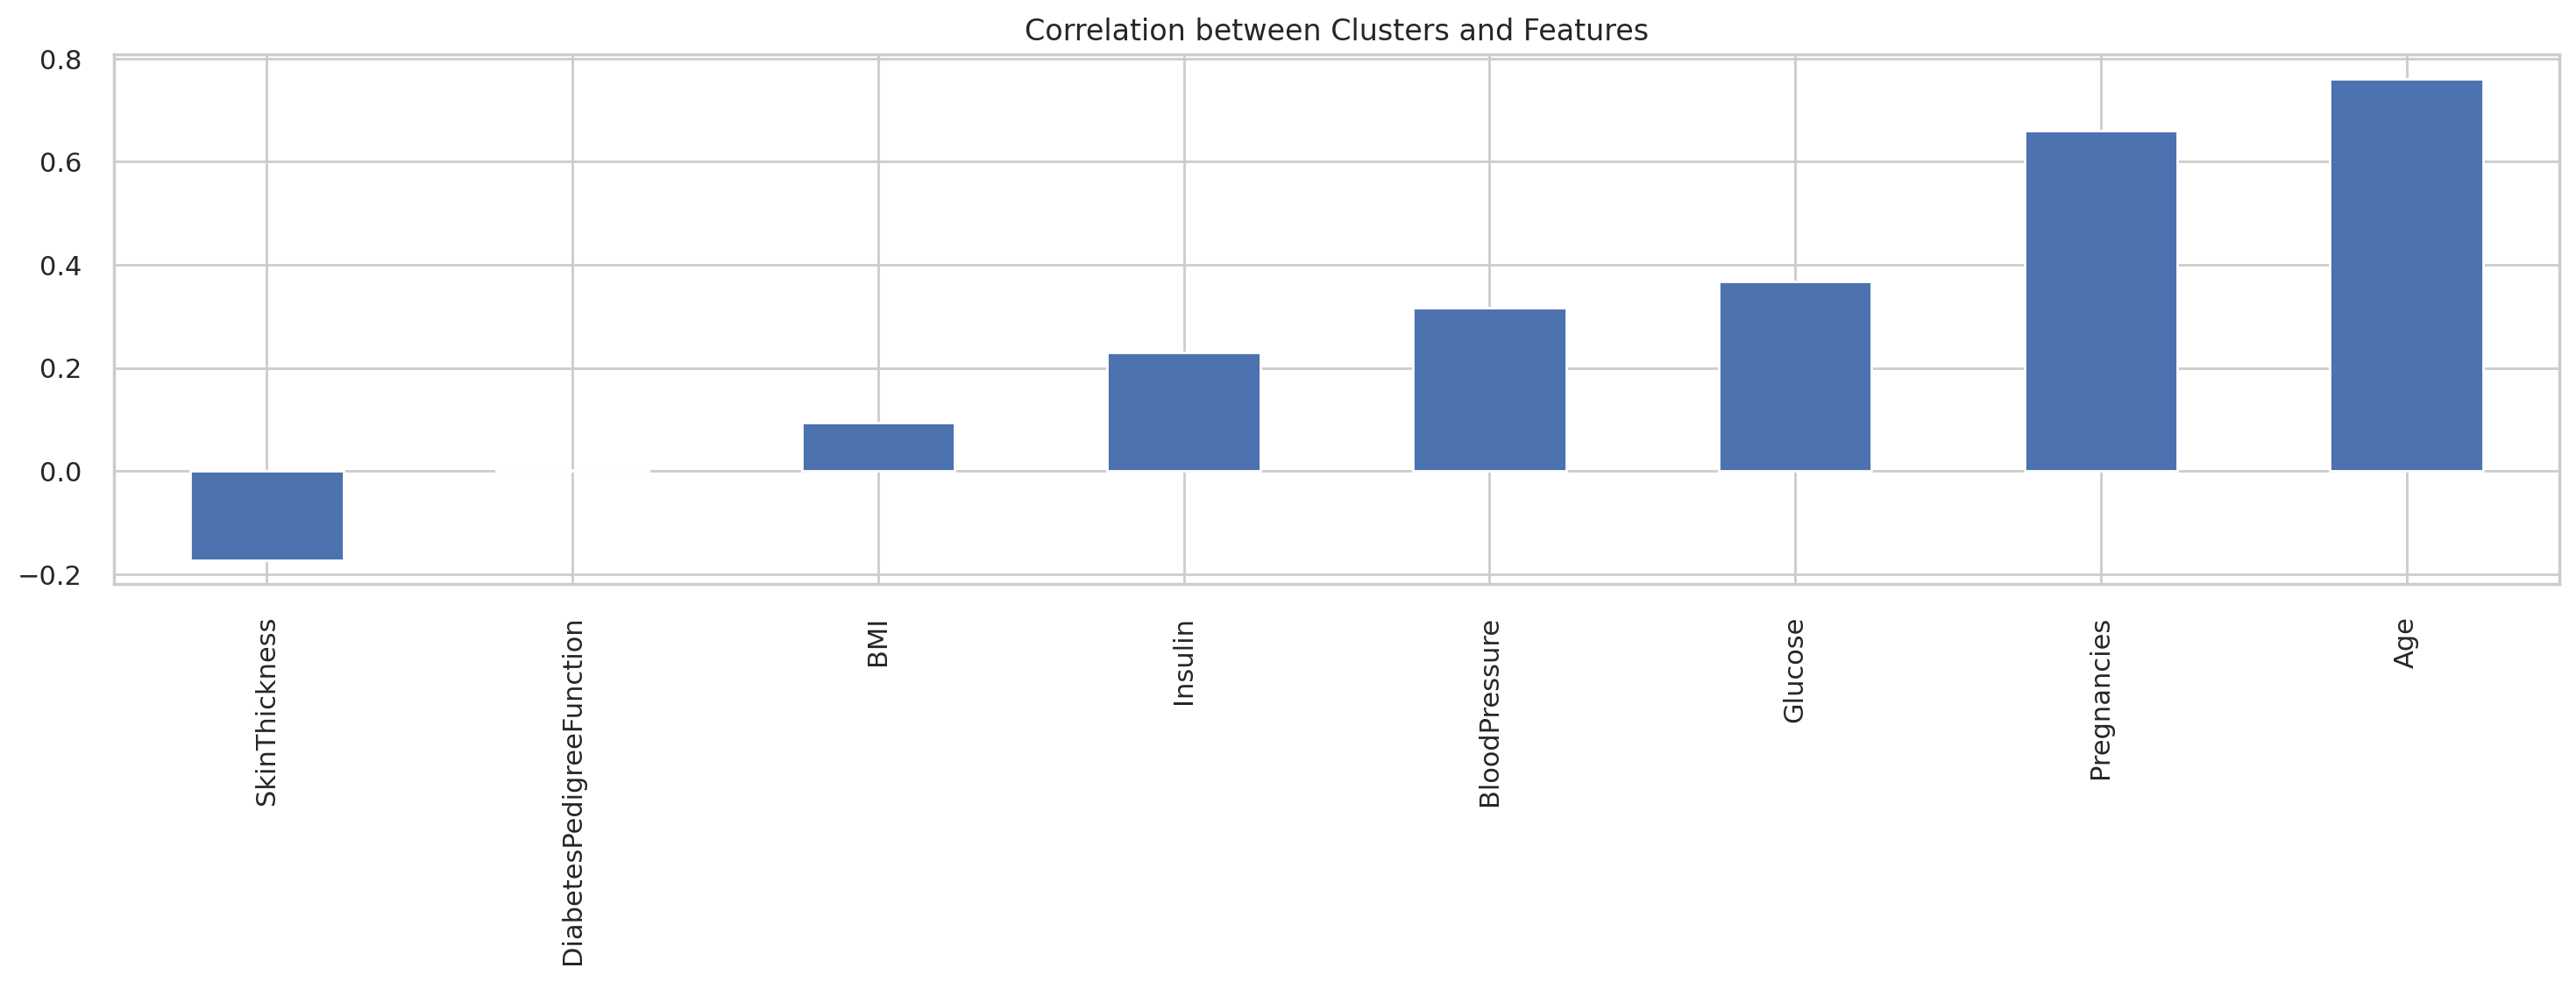

In [54]:
plt.figure(figsize=(18,4),dpi=200)
X.corr()["Cluster"].iloc[:-1].sort_values().plot(kind="bar")
plt.title("Correlation between Clusters and Features")
plt.show()

In [55]:
# Elbow Curve Method
ssd = []

for k in range(2,10):
    model = KMeans(n_clusters=k)
    model.fit(X)
    
    ssd.append(model.inertia_)

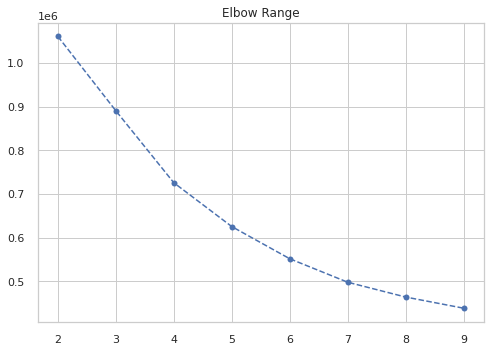

In [56]:
plt.plot(range(2,10),ssd,"o--")
plt.title("Elbow Range")
plt.show()

In [57]:
df_study.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,125.0,33.6,0.627,50,1
1,1,85,66,29,125.0,26.6,0.351,31,0
2,8,183,64,0,125.0,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1


In [59]:
X['Outcome'] = df_study['Outcome']

In [60]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Cluster,Outcome
0,6,148,72,35,125.0,33.6,0.627,50,1,1
1,1,85,66,29,125.0,26.6,0.351,31,0,0
2,8,183,64,0,125.0,23.3,0.672,32,1,1
3,1,89,66,23,94.0,28.1,0.167,21,0,0
4,0,137,40,35,168.0,43.1,2.288,33,0,1


In [62]:
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,roc_curve, classification_report,mean_squared_error,f1_score,recall_score
cm = confusion_matrix(X['Outcome'],X['Cluster'])
cm

array([[291, 112],
       [ 90, 122]])

In [65]:
X['Outcome'].value_counts()

0    403
1    212
Name: Outcome, dtype: int64

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['health', 'diabets']); ax.yaxis.set_ticklabels(['health', 'diabets']);

In [63]:
print(classification_report(X['Outcome'],X['Cluster']))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       403
           1       0.52      0.58      0.55       212

    accuracy                           0.67       615
   macro avg       0.64      0.65      0.64       615
weighted avg       0.68      0.67      0.68       615



DBSCAN

In [107]:
X = df_study.drop("Outcome",axis=1)
X.info()

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               615 non-null    int64  
 1   Glucose                   615 non-null    int64  
 2   BloodPressure             615 non-null    int64  
 3   SkinThickness             615 non-null    int64  
 4   Insulin                   615 non-null    float64
 5   BMI                       615 non-null    float64
 6   DiabetesPedigreeFunction  615 non-null    float64
 7   Age                       615 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 43.2 KB


In [68]:
outlier_percent = []

for eps in np.linspace(0.001,3,50):
    
    # Create Model
    dbscan = DBSCAN(eps=eps,min_samples=2*scaled_X.shape[1])
    dbscan.fit(scaled_X)
   
     
    # Log percentage of points that are outliers
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

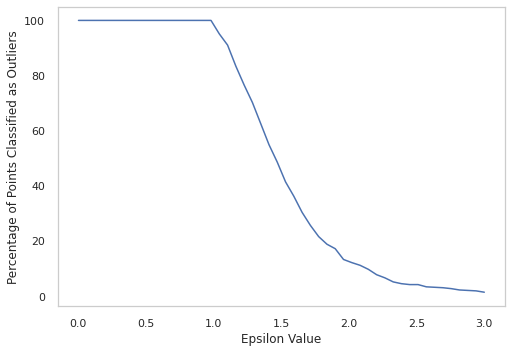

In [74]:
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")
plt.grid(False)
plt.show()

In [108]:
dbscan = DBSCAN(eps=1.5)

In [109]:
dbscan.fit(scaled_X)

DBSCAN(eps=1.5)

In [110]:
X['Cluster'] = dbscan.labels_

In [111]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Cluster
0,6,148,72,35,125.0,33.6,0.627,50,0
1,1,85,66,29,125.0,26.6,0.351,31,0
2,8,183,64,0,125.0,23.3,0.672,32,-1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,-1


In [112]:
X['Cluster'].value_counts()

 0    459
-1    137
 1     14
 2      5
Name: Cluster, dtype: int64

In [113]:
X['Outcome'] = df_study['Outcome']
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Cluster,Outcome
0,6,148,72,35,125.0,33.6,0.627,50,0,1
1,1,85,66,29,125.0,26.6,0.351,31,0,0
2,8,183,64,0,125.0,23.3,0.672,32,-1,1
3,1,89,66,23,94.0,28.1,0.167,21,0,0
4,0,137,40,35,168.0,43.1,2.288,33,-1,1


In [125]:
result= X[X['Cluster'] <= 0]

In [116]:
result['Cluster'].value_counts()

 0    459
-1    137
Name: Cluster, dtype: int64

In [117]:
result['Outcome'].value_counts()

0    390
1    206
Name: Outcome, dtype: int64

In [126]:
result['Cluster']= result['Cluster'] * -1

In [127]:
cm = confusion_matrix(result['Outcome'],result['Cluster'])
cm

array([[327,  63],
       [132,  74]])

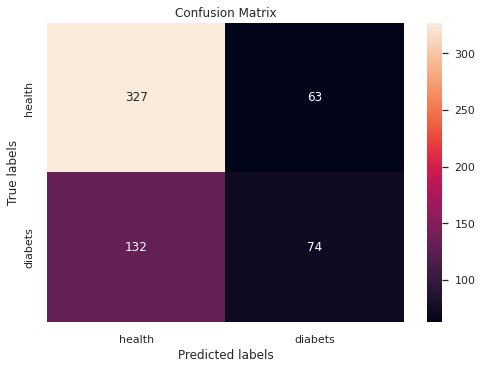

In [130]:


ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['health', 'diabets']); ax.yaxis.set_ticklabels(['health', 'diabets']);

In [129]:
print(classification_report(result['Outcome'],result['Cluster']))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       390
           1       0.54      0.36      0.43       206

    accuracy                           0.67       596
   macro avg       0.63      0.60      0.60       596
weighted avg       0.65      0.67      0.65       596

